Modelo para predicción de precios de casas
En este notebook construiremos un modelo para predecir el precio optimo que deberia tener una casa alquilada por airbnb usando la parte del dataset  original que contiene registros de casas unicamente, veremos si haciendo esta separación obtenemos un mejor modelo 

In [70]:
import pandas as pd
import numpy as np
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#! pip install py-AutoClean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
#! pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#! pip install --user pycaret
import pycaret as pycaret
from pycaret.regression import *
import lightgbm as lgb
import joblib


Leyendo el dataset que hemos preparado previamente

In [71]:
df=pd.read_csv('../datos_separados/datos_apto_casas_encoded_no_out.csv')

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41224 entries, 0 to 41223
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   41224 non-null  object 
 1   latitude                        41224 non-null  float64
 2   longitude                       41224 non-null  float64
 3   room_type                       41224 non-null  object 
 4   price                           41224 non-null  int64  
 5   minimum_nights                  41224 non-null  int64  
 6   calculated_host_listings_count  41224 non-null  int64  
 7   availability_365                41224 non-null  int64  
 8   number_of_reviews_ltm           41224 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 2.8+ MB


In [73]:
df.nunique()

neighbourhood                        33
latitude                          21374
longitude                         26970
room_type                             1
price                              1369
minimum_nights                      101
calculated_host_listings_count       76
availability_365                    366
number_of_reviews_ltm               118
dtype: int64

Los modelos de ML (algunos) requieren codificar las variables categoricas usando algun metodo antes de poder procesar los datos y arrojar resultados consistentes, en este caso usaremos la estrategia de one hot encoding para dcodificar las variables neighbourhood y room_type.

In [74]:

columna_a_codificar = 'neighbourhood'

# Crear el codificador One-Hot Encoder
onehot_encoder = OneHotEncoder()

# Ajustar y transformar la columna seleccionada con One-Hot Encoder
encoded_features = onehot_encoder.fit_transform(df[[columna_a_codificar]])

# Crear un nuevo DataFrame con las características codificadas
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=onehot_encoder.get_feature_names_out([columna_a_codificar]))

# Concatenar el DataFrame codificado con el DataFrame original
data_encoded = pd.concat([df.drop([columna_a_codificar], axis=1), encoded_df], axis=1)



In [75]:
columna_a_codificar = 'room_type'

# Crear el codificador One-Hot Encoder
onehot_encoder = OneHotEncoder()

# Ajustar y transformar la columna seleccionada con One-Hot Encoder
encoded_features = onehot_encoder.fit_transform(data_encoded[[columna_a_codificar]])

# Crear un nuevo DataFrame con las características codificadas
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=onehot_encoder.get_feature_names_out([columna_a_codificar]))

# Concatenar el DataFrame codificado con el DataFrame original
data_encoded = pd.concat([data_encoded.drop([columna_a_codificar], axis=1), encoded_df], axis=1)

In [76]:
data_encoded

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews_ltm,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,...,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,room_type_Entire home/apt
0,51.52851,-0.07426,90,5,1,222,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,51.51464,-0.20004,297,14,1,180,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,51.48780,-0.16813,75,3,1,70,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,51.52055,-0.18317,204,2,1,193,66,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,51.52195,-0.14094,379,4,5,249,8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41219,51.48313,-0.01235,104,5,1,89,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41220,51.50914,-0.10192,201,3,1,0,12,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
41221,51.40571,-0.35325,246,3,1,4,6,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41222,51.41029,-0.35975,250,3,1,2,4,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Separando el dataset en train y test para entrenar el modelo y probarlo en datos desconocidos, dejamos un tamaño para el set de prueba del 30 % del set original

In [77]:
# se toman todas las columnas menos, la variable objetivo
X = data_encoded.drop('price', axis=1)
# se selecciona la columna de la clase
y = data_encoded['price']
# Split dataset into training set and test set
#random_state generador de numero aleatorios (semilla usada por el generador)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,shuffle=True) # 70% 

Aplicando el scaler a X_train, repetir para X_test con el mismo scaler, este procedimiento escala las variables numericas para reducir la volatilidad y mejorar los resultados del modelo al obtener los mismos datos en un rango menor sin perder la proporcion que los datos guardan entre ellos.

In [78]:
# Seleccionar las columnas numéricas que deseas escalar
columnas_a_escalar = [ 'latitude', 'longitude',
       'minimum_nights', 'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm']

# Crear el objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar las columnas seleccionadas con el StandardScaler
X_train[columnas_a_escalar] = scaler.fit_transform(X_train[columnas_a_escalar])

In [79]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)





XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Procesando en conjunto de prueba con los mismos procedimientos:

In [80]:
# Seleccionar las columnas numéricas que deseas escalar
columnas_a_escalar = [ 'latitude', 'longitude',
       'minimum_nights', 'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm']

# Crear el objeto StandardScaler
scaler = StandardScaler()

# Ajustar y transformar las columnas seleccionadas con el StandardScaler
X_test[columnas_a_escalar] = scaler.fit_transform(X_test[columnas_a_escalar])

In [81]:
X_test.head()

,latitude,longitude,minimum_nights,calculated_host_listings_count,availability_365,number_of_reviews_ltm,neighbourhood_Barking and Dagenham,neighbourhood_Barnet,neighbourhood_Bexley,neighbourhood_Brent,...,neighbourhood_Newham,neighbourhood_Redbridge,neighbourhood_Richmond upon Thames,neighbourhood_Southwark,neighbourhood_Sutton,neighbourhood_Tower Hamlets,neighbourhood_Waltham Forest,neighbourhood_Wandsworth,neighbourhood_Westminster,room_type_Entire home/apt
32815,-0.715531,-0.776072,-0.104256,-0.318557,1.640402,0.218146,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22218,0.101121,0.656055,0.605762,-0.318557,1.077950,-0.113131,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
26623,0.344189,-0.630903,0.162001,-0.342446,-0.845028,-0.223557,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6631,-2.071395,-0.502618,-0.148632,0.183106,0.591505,-0.444409,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36550,-0.408998,-0.820595,-0.148632,-0.151336,0.264674,-0.444409,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [82]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [83]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.28502778860017963 
Mean Squared Error: 159657.90285020112
Mean Absolute Error: 117.59155559860035
Root Mean Squared Error: 399.57214974294834


Entrenando el modelo XGBoost en el conjunto con las 15  mejores caracteristicas seleccionadas.

In [84]:
model_selectk = xgb.XGBRegressor()
model_selectk.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [85]:
X_test_selected=X_test

In [86]:
# Realizar predicciones en el conjunto de prueba
y_pred_selectk= model_selectk.predict(X_test_selected)

In [87]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred_selectk)
mae = mean_absolute_error(y_test, y_pred_selectk)

rmse = mean_squared_error(y_test, y_pred_selectk, squared=False)
r2 = r2_score(y_test, y_pred_selectk)


print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.28502778860017963 
Mean Squared Error: 159657.90285020112
Mean Absolute Error: 117.59155559860035
Root Mean Squared Error: 399.57214974294834


Modelo con ajuste de hiperparametros

In [88]:
# Definir los hiperparámetros que deseas probar
"""param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5],
}

# Crear el modelo XGBoost
model_hip = xgb.XGBRegressor()

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=model_hip, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y el modelo final
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba utilizando el modelo final
y_pred_hip = best_model.predict(X_test)"""


"param_grid = {\n    'n_estimators': [100, 200, 300],\n    'learning_rate': [0.01, 0.1, 0.3],\n    'max_depth': [3, 4, 5],\n}\n\n# Crear el modelo XGBoost\nmodel_hip = xgb.XGBRegressor()\n\n# Realizar la búsqueda en cuadrícula con validación cruzada\ngrid_search = GridSearchCV(estimator=model_hip, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')\ngrid_search.fit(X_train, y_train)\n\n# Obtener los mejores hiperparámetros y el modelo final\nbest_params = grid_search.best_params_\nbest_model = grid_search.best_estimator_\n\n# Realizar predicciones en el conjunto de prueba utilizando el modelo final\ny_pred_hip = best_model.predict(X_test)"

In [89]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred_hip)
mae = mean_absolute_error(y_test, y_pred_hip)

rmse = mean_squared_error(y_test, y_pred_hip, squared=False)
r2 = r2_score(y_test, y_pred_hip)
print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.24788654856795844 
Mean Squared Error: 167951.78112721894
Mean Absolute Error: 120.28763881132951
Root Mean Squared Error: 409.8192054152891


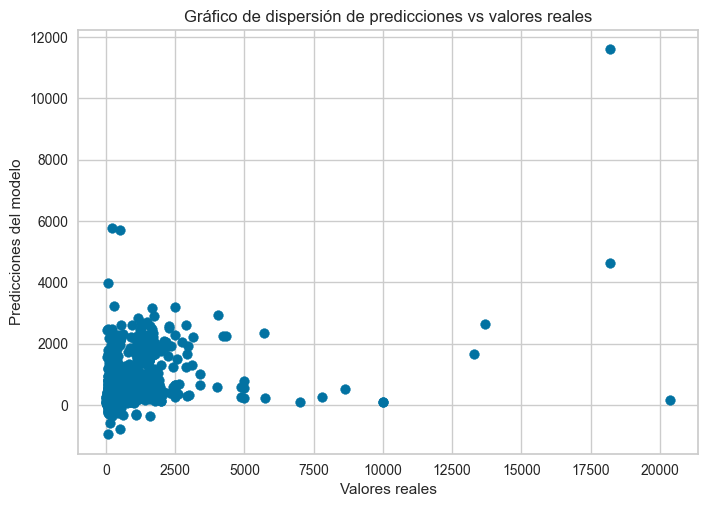

In [90]:

# y_test son los valores reales y y_pred son las predicciones del modelo
plt.scatter(y_test, y_pred_hip)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones del modelo")
plt.title("Gráfico de dispersión de predicciones vs valores reales")
plt.show()


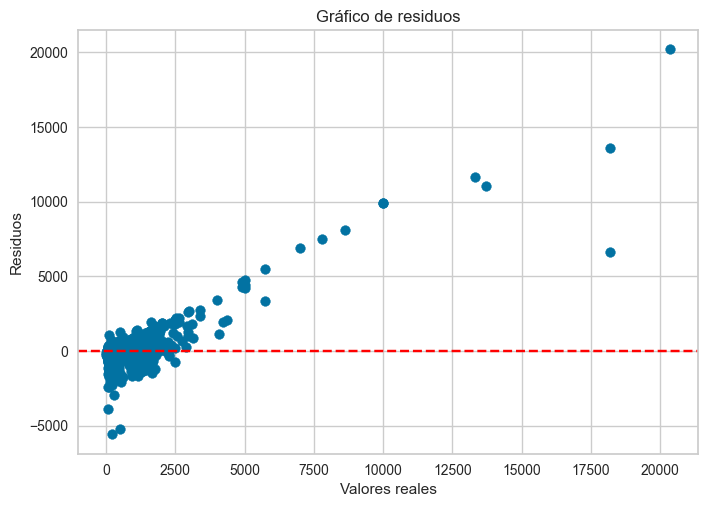

In [91]:
residuals = y_test - y_pred_hip
plt.scatter(y_test, residuals)
plt.xlabel("Valores reales")
plt.ylabel("Residuos")
plt.title("Gráfico de residuos")
plt.axhline(y=0, color='red', linestyle='--')  # Línea en cero para referencia
plt.show()


Probar que recomendaciones de modelos nos da la libreria de automl pycaret

Partiendo el set original para modelamiento y pruebas para separar datos que el modelo no conoce y asi testear los resultados de las estimaciones.

In [92]:
data = df.sample(frac=0.9, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (37102, 9)
Unseen Data For Predictions: (4122, 9)


In [93]:
#s = setup(data = data, target = 'price', session_id=123,normalize = True,remove_multicollinearity = True, multicollinearity_threshold = 0.3)

In [94]:
#best = compare_models()

Entrenaremos un LightGBM con las variables seleccionadas anteriormente mediante el metodo selectKbest y  feature selection con ajuste de hiperparametros para ver como se comporta:

In [95]:
# Crea el regresor LightGBM
lgb_model = lgb.LGBMRegressor(objective='regression', random_state=42)

# Entrena el modelo en los datos de entrenamiento
lgb_model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = lgb_model.predict(X_test)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 28856, number of used features: 39
[LightGBM] [Info] Start training from score 226.791586


In [96]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.3154650548208937 
Mean Squared Error: 152861.06513286085
Mean Absolute Error: 114.53318246286705
Root Mean Squared Error: 390.9745070114685


In [97]:
# Define la grilla de hiperparámetros a explorar
param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': [20, 30, 40, 50, 60],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [100, 200, 300, 400]
}

# Crea un objeto RandomizedSearchCV
random_search = RandomizedSearchCV(
    lgb_model, param_distributions=param_grid, n_iter=50, cv=3, scoring='neg_mean_squared_error', random_state=42)



In [98]:
# Realiza la búsqueda aleatoria en los datos de entrenamiento
random_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Realiza predicciones en el conjunto de prueba con el mejor modelo encontrado
y_pred = random_search.best_estimator_.predict(X_test)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.507878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 19237, number of used features: 39
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 221.635598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [99]:
# Evaluar el rendimiento del modelo utilizando el error cuadrático medio (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print(f"R-squared: {r2} \nMean Squared Error: {mse}\nMean Absolute Error: {mae}\nRoot Mean Squared Error: {rmse}")

R-squared: 0.2979567951369898 
Mean Squared Error: 156770.77236220328
Mean Absolute Error: 128.64113180784364
Root Mean Squared Error: 395.94289027864016


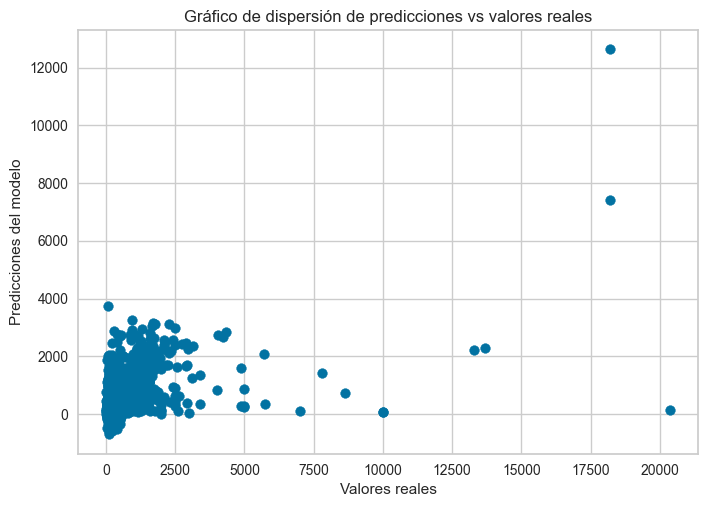

In [100]:

# y_test son los valores reales y y_pred son las predicciones del modelo
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones del modelo")
plt.title("Gráfico de dispersión de predicciones vs valores reales")
plt.show()


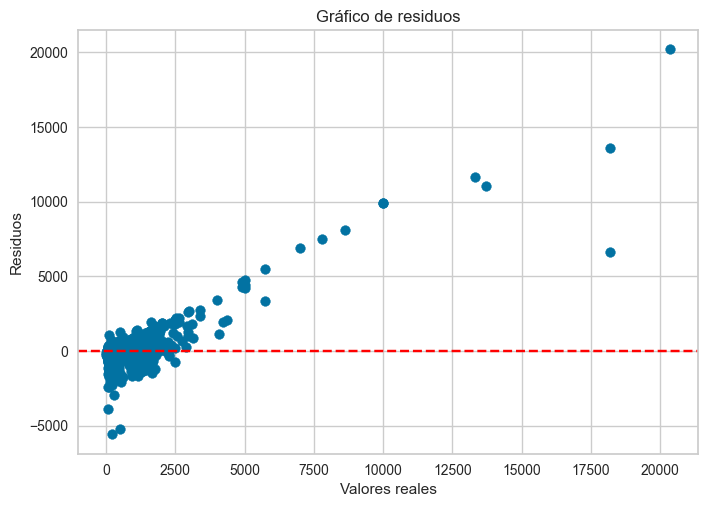

In [101]:
residuals = y_test - y_pred_hip
plt.scatter(y_test, residuals)
plt.xlabel("Valores reales")
plt.ylabel("Residuos")
plt.title("Gráfico de residuos")
plt.axhline(y=0, color='red', linestyle='--')  # Línea en cero para referencia
plt.show()


Guardando el modelo en un archivo joblib

In [102]:

# Ruta del archivo donde guardarás el modelo
ruta_archivo_modelo = "../modelos/lgbm_apto_casas.joblib"

# Guardar el modelo usando joblib
joblib.dump(lgb_model, ruta_archivo_modelo)

['../modelos/lgbm_apto_casas.joblib']